# K-Means Cluster Example

### The purpose of this model is to group data on voter concerns by congressional district prior to the 2022 midterm elections. The data was compiled and cleaned by Google for public use from results of Google, YouTube and other searches. Each congressional district has voter issues ranked from First to Tenth. This model uses K-Means cluster algorithm to group the districts. This model has many uses, including organizations tailoring messaging to different districts based on their group placement and understanding voter concern trends locally and nationwide.

## 01 - Import Libraries

In [1]:
# Import Libraries
import pandas as pd
import requests
import io
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from yellowbrick.cluster import KElbowVisualizer
from sklearn.preprocessing import OrdinalEncoder

## 02 - Upload & Explore Data

In [2]:
# Pull data set from source URL
url = "https://raw.githubusercontent.com/googletrends/data/master/20221017_TopIssuesByDistrict.csv"
s = requests.get(url).content
df = pd.read_csv(io.StringIO(s.decode('utf-8')))

In [3]:
# View data set
print(df)

    district FIRST SECOND     THIRD        FOURTH         FIFTH         SIXTH  \
0      AK-01   Job  Taxes    Russia      Firearms       Ukraine         China   
1      AL-01   Job  Taxes  Firearms        Russia         Wages     Joe Biden   
2      AL-02   Job  Taxes  Firearms         Wages       Ukraine         China   
3      AL-03   Job  Taxes     Wages      Firearms        Russia         China   
4      AL-04   Job  Taxes  Firearms        Russia         Wages       Ukraine   
..       ...   ...    ...       ...           ...           ...           ...   
430    WI-07   Job  Taxes   Ukraine  Donald Trump      Firearms        Russia   
431    WI-08   Job  Taxes   Ukraine        Russia         Crime  Donald Trump   
432    WV-01   Job  Taxes  Firearms         Wages        Russia  Donald Trump   
433    WV-02   Job  Taxes  Firearms         Wages        Russia  Donald Trump   
434    WY-01   Job  Taxes  Firearms       Ukraine  Donald Trump        Russia   

          SEVENTH        EI

In [5]:
print(df.head(20)) # first 20 entries

   district FIRST SECOND         THIRD        FOURTH         FIFTH  \
0     AK-01   Job  Taxes        Russia      Firearms       Ukraine   
1     AL-01   Job  Taxes      Firearms        Russia         Wages   
2     AL-02   Job  Taxes      Firearms         Wages       Ukraine   
3     AL-03   Job  Taxes         Wages      Firearms        Russia   
4     AL-04   Job  Taxes      Firearms        Russia         Wages   
5     AL-05   Job  Taxes         Wages       Ukraine      Firearms   
6     AL-06   Job  Taxes      Firearms         Wages       Ukraine   
7     AL-07   Job  Taxes         Wages      Firearms  Unemployment   
8     AR-01   Job  Taxes      Firearms         Wages       Ukraine   
9     AR-02   Job  Taxes      Firearms         Wages     Joe Biden   
10    AR-03   Job  Taxes         Wages        Russia      Firearms   
11    AR-04   Job  Taxes      Firearms         Wages  Donald Trump   
12    AZ-01   Job  Taxes  Donald Trump       Ukraine     Joe Biden   
13    AZ-02   Job  T

In [6]:
print(df.tail(20)) # last 20 entries

    district FIRST SECOND         THIRD        FOURTH                   FIFTH  \
415    WA-02   Job  Taxes       Ukraine  Donald Trump  The border/immigration   
416    WA-03   Job  Taxes     Joe Biden       Ukraine                   Wages   
417    WA-04   Job  Taxes         Wages       Ukraine                  Russia   
418    WA-05   Job  Taxes       Ukraine        Russia                   Wages   
419    WA-06   Job  Taxes       Ukraine  Donald Trump                  Russia   
420    WA-07   Job  Taxes       Ukraine        Russia                   China   
421    WA-08   Job  Taxes       Ukraine  Donald Trump                  Russia   
422    WA-09   Job  Taxes       Ukraine        Russia                   China   
423    WA-10   Job  Taxes         Wages       Ukraine                  Russia   
424    WI-01   Job  Taxes  Donald Trump       Ukraine                  Russia   
425    WI-02   Job  Taxes       Ukraine  Donald Trump                  Russia   
426    WI-03   Job  Taxes  D

In [7]:
print(df.dtypes) # check data types

district    object
FIRST       object
SECOND      object
THIRD       object
FOURTH      object
FIFTH       object
SIXTH       object
SEVENTH     object
EIGHTH      object
NINTH       object
TENTH       object
dtype: object


In [8]:
print(df.info()) # check data info

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 435 entries, 0 to 434
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   district  435 non-null    object
 1   FIRST     435 non-null    object
 2   SECOND    435 non-null    object
 3   THIRD     435 non-null    object
 4   FOURTH    435 non-null    object
 5   FIFTH     435 non-null    object
 6   SIXTH     435 non-null    object
 7   SEVENTH   435 non-null    object
 8   EIGHTH    435 non-null    object
 9   NINTH     435 non-null    object
 10  TENTH     435 non-null    object
dtypes: object(11)
memory usage: 37.5+ KB
None


In [9]:
print(df.describe()) # check descriptive details

       district FIRST SECOND    THIRD  FOURTH   FIFTH   SIXTH SEVENTH  \
count       435   435    435      435     435     435     435     435   
unique      435     2      4       12      12      14      14      15   
top       AK-01   Job  Taxes  Ukraine  Russia  Russia  Russia   China   
freq          1   430    424      116      99     147      95      87   

           EIGHTH      NINTH  TENTH  
count         435        435    435  
unique         16         15     18  
top     Joe Biden  Joe Biden  Crime  
freq          105        128    140  


In [10]:
# Check unique values of columns
print(pd.Series(list(map(set,df.values.T)),index=df.columns))

district    {MD-02, NY-12, NC-07, OH-07, CA-37, OR-03, NY-...
FIRST                                            {Taxes, Job}
SECOND                        {Taxes, Job, Stimulus, Ukraine}
THIRD       {Stimulus, Donald Trump, Unemployment, Wages, ...
FOURTH      {Student loan forgiveness, Stimulus, Donald Tr...
FIFTH       {Student loan forgiveness, Stimulus, The borde...
SIXTH       {Stimulus, Economy, The border/immigration, Do...
SEVENTH     {Student loan forgiveness, Stimulus, The borde...
EIGHTH      {Student loan forgiveness, Stimulus, The borde...
NINTH       {Student loan forgiveness, Stimulus, The borde...
TENTH       {Student loan forgiveness, Stimulus, Russia, D...
dtype: object


## 03 - Preprocessing

In [11]:
# Drop 'district' column to explore ranking columns
cols = df.drop(['district'], axis=1)
print(cols)

    FIRST SECOND     THIRD        FOURTH         FIFTH         SIXTH  \
0     Job  Taxes    Russia      Firearms       Ukraine         China   
1     Job  Taxes  Firearms        Russia         Wages     Joe Biden   
2     Job  Taxes  Firearms         Wages       Ukraine         China   
3     Job  Taxes     Wages      Firearms        Russia         China   
4     Job  Taxes  Firearms        Russia         Wages       Ukraine   
..    ...    ...       ...           ...           ...           ...   
430   Job  Taxes   Ukraine  Donald Trump      Firearms        Russia   
431   Job  Taxes   Ukraine        Russia         Crime  Donald Trump   
432   Job  Taxes  Firearms         Wages        Russia  Donald Trump   
433   Job  Taxes  Firearms         Wages        Russia  Donald Trump   
434   Job  Taxes  Firearms       Ukraine  Donald Trump        Russia   

          SEVENTH        EIGHTH         NINTH         TENTH  
0       Joe Biden         Wages  Donald Trump  Unemployment  
1         U

In [12]:
# View number of unique entries, most frequent entry and frequency of most frequent entry for each ranking
cols.describe().transpose()

,count,unique,top,freq
FIRST,435,2,Job,430
SECOND,435,4,Taxes,424
THIRD,435,12,Ukraine,116
FOURTH,435,12,Russia,99
FIFTH,435,14,Russia,147
SIXTH,435,14,Russia,95
SEVENTH,435,15,China,87
EIGHTH,435,16,Joe Biden,105
NINTH,435,15,Joe Biden,128
TENTH,435,18,Crime,140


In [13]:
# View percentage of each issue per ranking
cat_df = cols.melt(value_name='issue', var_name='ranking')
cat_df = cat_df.groupby(['ranking', 'issue']).size().reset_index(name='count')
cat_df['perc'] = cat_df['count'].div(cat_df.groupby('ranking')['count'].transform('sum')).mul(100)
print (cat_df.to_string())

     ranking                     issue  count       perc
0     EIGHTH                     China     68  15.632184
1     EIGHTH                     Crime     21   4.827586
2     EIGHTH              Donald Trump     66  15.172414
3     EIGHTH                  Firearms     33   7.586207
4     EIGHTH                Gas prices      1   0.229885
5     EIGHTH               Health Care     16   3.678161
6     EIGHTH               Immigration      1   0.229885
7     EIGHTH                 Inflation      6   1.379310
8     EIGHTH                 Joe Biden    105  24.137931
9     EIGHTH                    Russia     19   4.367816
10    EIGHTH                  Stimulus      9   2.068966
11    EIGHTH  Student loan forgiveness      6   1.379310
12    EIGHTH    The border/immigration      8   1.839080
13    EIGHTH                   Ukraine     32   7.356322
14    EIGHTH              Unemployment     15   3.448276
15    EIGHTH                     Wages     29   6.666667
16     FIFTH                   

## 04 - Build the Model

In [50]:
# Encode data using ordinal encoding
enc = OrdinalEncoder()
df_encode = enc.fit_transform(cols)
print(df_encode)

[[ 0.  2.  6. ... 15.  2. 15.]
 [ 0.  2.  3. ...  0.  2.  1.]
 [ 0.  2.  3. ...  8.  2.  1.]
 ...
 [ 0.  2.  3. ...  0.  7.  1.]
 [ 0.  2.  3. ...  8. 12.  1.]
 [ 0.  2.  3. ...  8.  1.  0.]]


In [51]:
# Standardize data set
scaler_s = StandardScaler()
df_encode = scaler_s.fit_transform(df_encode)

C:\Users\decaf\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\decaf\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\Users\decaf\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\decaf\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environme

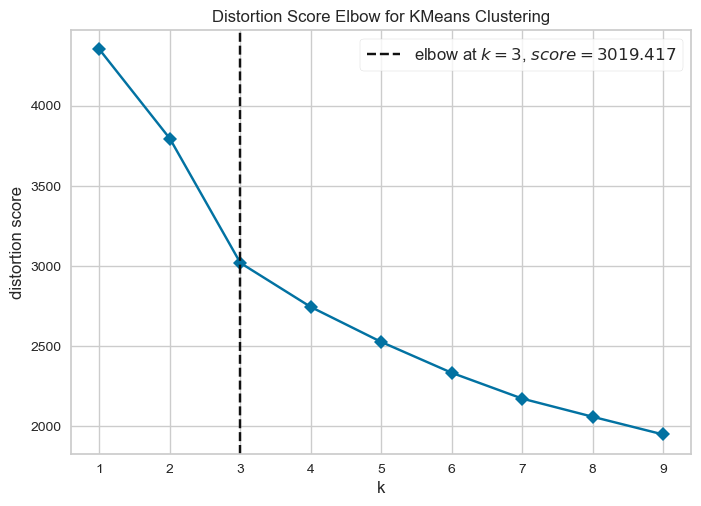

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [52]:
# Employ the Elbow Method to determine k
model = KMeans()
visualizer = KElbowVisualizer(model, k=(1,10), timings=False)
visualizer.fit(df_encode)
visualizer.show()

In [53]:
# Transform data using PCA
pca = PCA()
X = pca.fit_transform(df_encode)

In [54]:
# Initialize the number of clusters for KMeans
km = KMeans(n_clusters=3) # number of clusters from KElbowVisualizer
label = km.fit_predict(X)
unique_labels = np.unique(label)

C:\Users\decaf\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\decaf\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


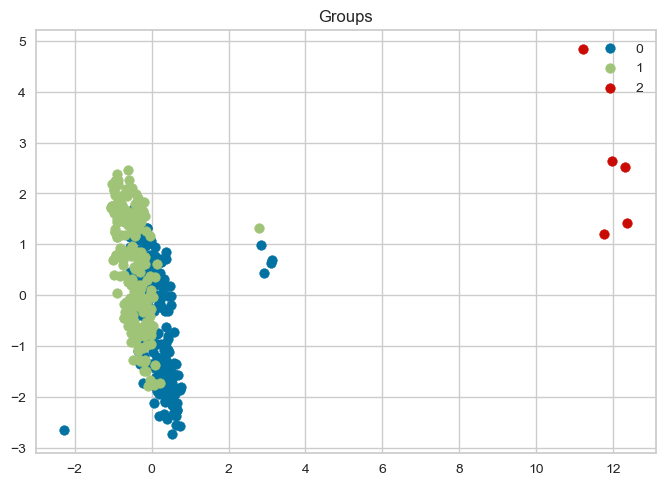

In [55]:
# Display clusters in scatter plot
for i in unique_labels:
    plt.scatter(X[label==i,0], X[label==i, 1], label=i)

plt.legend()
plt.title('Groups')
plt.show()

In [56]:
# Display array of cluster membership
km.labels_

array([0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1,
       1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 1,
       1, 1, 0, 1, 1, 0, 0, 0, 2, 0, 0, 1, 2, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0,
       0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0,
       1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1,
       1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0,
       1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 1, 0, 0, 2, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1,
       0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0,
       0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0,
       0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1,

In [57]:
# Check if any rows missing from set
arrayName = km.labels_
len(arrayName) # should be 435

435

In [58]:
# For loop that counts the number of districts in each cluster group
group0 = 0
group1 = 0
group2 = 0

for i in arrayName:
    if i == 0:
        group0 = group0 + 1
    elif i == 1:
        group1 = group1 + 1
    else:
        group2 = group2 + 1
    
print("The number of districts in Group 0 is", group0)
print("The number of districts in Group 1 is", group1)
print("The number of districts in Group 2 is", group2)

The number of districts in Group 0 is 212
The number of districts in Group 1 is 218
The number of districts in Group 2 is 5


In [59]:
# Calculate Silhoutte Score
score = silhouette_score(X, km.labels_, metric='euclidean')
# Print the score
print('Silhouette Score: %.3f' % score)

Silhouette Score: 0.142


## 05 - Use Example: Compare District Groups within the Same State

In [60]:
# Compare groups in the state of Illinois

# Print full list of districts
print(df['district'].to_string())

0      AK-01
1      AL-01
2      AL-02
3      AL-03
4      AL-04
5      AL-05
6      AL-06
7      AL-07
8      AR-01
9      AR-02
10     AR-03
11     AR-04
12     AZ-01
13     AZ-02
14     AZ-03
15     AZ-04
16     AZ-05
17     AZ-06
18     AZ-07
19     AZ-08
20     AZ-09
21     CA-01
22     CA-02
23     CA-03
24     CA-04
25     CA-05
26     CA-06
27     CA-07
28     CA-08
29     CA-09
30     CA-10
31     CA-11
32     CA-12
33     CA-13
34     CA-14
35     CA-15
36     CA-16
37     CA-17
38     CA-18
39     CA-19
40     CA-20
41     CA-21
42     CA-22
43     CA-23
44     CA-24
45     CA-25
46     CA-26
47     CA-27
48     CA-28
49     CA-29
50     CA-30
51     CA-31
52     CA-32
53     CA-33
54     CA-34
55     CA-35
56     CA-36
57     CA-37
58     CA-38
59     CA-39
60     CA-40
61     CA-41
62     CA-42
63     CA-43
64     CA-44
65     CA-45
66     CA-46
67     CA-47
68     CA-48
69     CA-49
70     CA-50
71     CA-51
72     CA-52
73     CO-01
74     CO-02
75     CO-03
76     CO-04

In [61]:
# Find the range of Illinois districts
# Print array position that matches row of district
print(arrayName[137:154])

[0 0 1 1 0 1 0 0 0 0 1 0 0 1 0 1 1]


In [62]:
# Narrow down to a specific district
# Find IL-12 in list
# Print array position that matches row of district
print(arrayName[148])

0


In [63]:
# Compare with IL-04
print(arrayName[140])

1
